# Loading software

In [152]:
from fretbursts import *
sns = init_notebook()
import lmfit
import phconvert
import os
from fretbursts.burstlib_ext import burst_search_and_gate

# Name and Load in data

first name the data file and check it exists, it will look for the file starting from inside the "Anaconda Projects Folder"

In [200]:
filename = "definitiveset/1ax.hdf5"
if os.path.isfile(filename):
    print("File found")
else:
    print("File not found, check file name is correct")

File found


Load in the file and set correction coefficients

You may get warnings that some parameters are not defined in the file, this is fine as they will be defined in this workbook anyway

In [154]:
d = loader.photon_hdf5(filename)
d.leakage = 0.0
d.dir_ex = 0.0
d.gamma = 1.0
d.beta = 1.0

WARNING fretbursts.loader
    No offset found, assuming offset = 0.
WARNING fretbursts.loader
    No offset found, assuming offset = 0.
WARNING fretbursts.loader

        The current file lacks the alternation period defintion.
        You will need to manually add this info using:

          d.add(D_ON=D_ON, A_ON=A_ON)

        where `d` is a Data object and D_ON/A_ON is a tuple with start/stop
        values defining the D/A excitation excitation period. Values are in
        raw timestamps units.
        
WARNING fretbursts.loader

        The current file lacks the alternation period defintion.
        You will need to manually add this info using:

          d.add(D_ON=D_ON, A_ON=A_ON)

        where `d` is a Data object and D_ON/A_ON is a tuple with start/stop
        values defining the D/A excitation excitation period. Values are in
        raw timestamps units.
        


# Check alternation cycle is correct

first define alternation parameters

In [155]:
d.add(det_donor_accept = (0, 1),
    alex_period = 10000,
    offset = 0,
    D_ON = (0, 4500),
    A_ON = (5000, 9500))

If this is correct, the following histogram should look correct. It is a combined plot of every photon that arrives over the supplied alternation periods. 

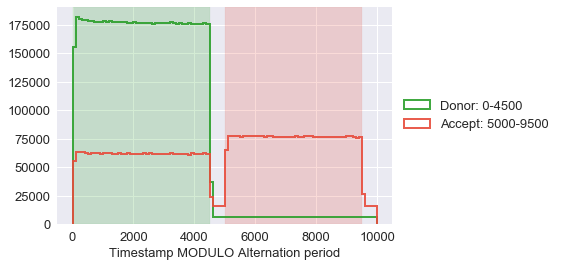

In [156]:
bpl.plot_alternation_hist(d)

IF THE ABOVE HISTOGRAM LOOKS WRONG: then the supplied alternation parameters do not match up to the alternation of the lasers in the data. This could be because the lasers were actually on a different alternation, or because the data set doesn't start at zero so is frame shifted.

IF THE ABOVE HISTOGRAM LOOKS CORRECT: execute the next command which rewrites the time stamps into groups based on their excitation period. If you want to change the alternation period after this you will have to reload the data into FRET busts.

In [157]:
loader.alex_apply_period(d)
time = d.time_max
print('Total data time = %s'%time)

# Total photons (after ALEX selection):    14,487,665
#  D  photons in D+A excitation periods:    8,245,518
#  A  photons in D+A excitation periods:    6,242,147
# D+A photons in  D  excitation period:    10,735,826
# D+A photons in  A  excitation period:     3,751,839

Total data time = 10799.90933468


The following will plot the time trace 

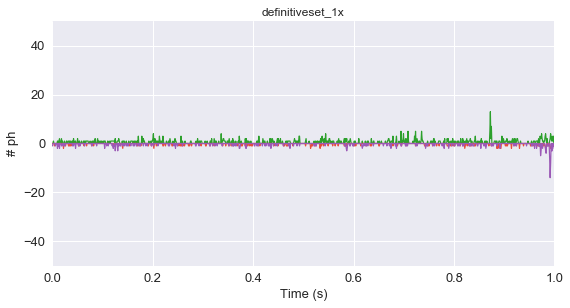

In [158]:
dplot(d, timetrace, binwidth=1e-3, tmin=0, tmax=10)
plt.xlim(0.0,1);
plt.ylim(-50,50);

# Background Estimation

Background estimation works by plotting log of photons by the delay between them, assuming a poisson distribution of photon arrivals and fitting a line. The plot will contain single molecule bursts however, so a threshold (in microseconds) has to be defined where the fit begins. There are better ways of finding the threshold (TBD) but this will work for now

 - Calculating BG rates ... [DONE]


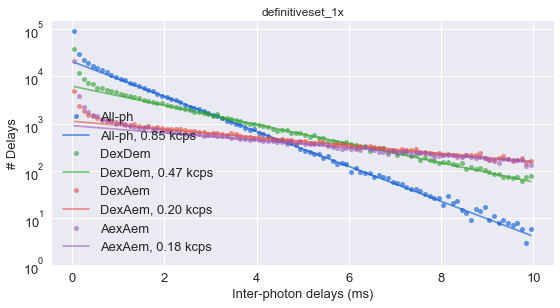

In [160]:
threshold = 1500
d.calc_bg(bg.exp_fit, time_s=300, tail_min_us=(threshold))
dplot(d, hist_bg, show_fit=True)

This code lets you set the threshold individually for each photon stream, note that the fourth stream counts AD photons which are effectively negligible

In [98]:
d.ph_streams

[Ph_sel(Dex='DAem', Aex='DAem'),
 Ph_sel(Dex='Dem', Aex=None),
 Ph_sel(Dex='Aem', Aex=None),
 Ph_sel(Dex=None, Aex='Dem'),
 Ph_sel(Dex=None, Aex='Aem')]

 - Calculating BG rates ... [DONE]


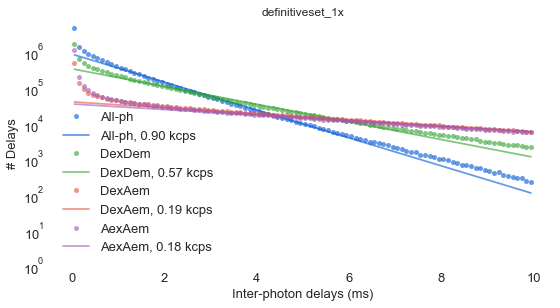

In [99]:
d.calc_bg(bg.exp_fit, time_s=time, tail_min_us=(1000, 500, 1500, 0, 1800),)
dplot(d, hist_bg, show_fit=True)

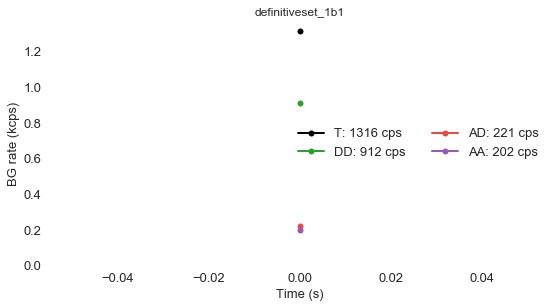

In [52]:
dplot(d, timetrace_bg);

# Burst Searching and Selecting for Donor Only

M = the number of photons to look at at any time
F = the number of times higher than the background the photon rate must be to be considered a burst
L = the number of photons that must be in a burst to be considered a burst

The burst selection then selects only bursts that are size th1 or higher, and lower than th2. add_naa=True ensures acceptor photons under acceptor excitation are encluded in the search.

In [187]:
d.burst_search(L=10, m=10, F=45)
ds = d.select_bursts(select_bursts.size, add_naa=True, th1=50)
#ds2 = d.select_bursts(select_bursts.size, th1=100,)
#ds2 = ds2.select_bursts(select_bursts.naa, th1=-10, th2=2)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


# Analysis

now we can start plotting and fitting the data

The following command will plot a hexogram ES, note that it will likely throw up errors with donor only populations as there will not be sufficient data 

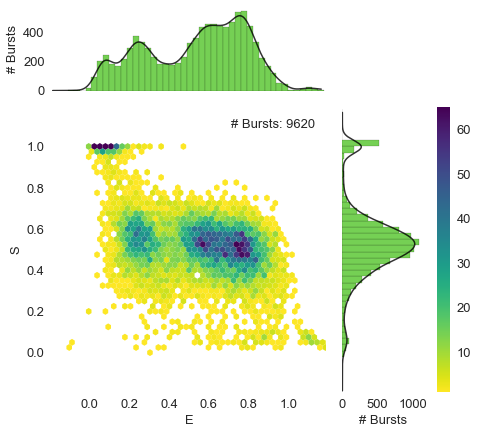

In [188]:
plt.rcParams['axes.facecolor'] = 'white'
grids = False
colourscheme = 'viridis_r'
g=alex_jointplot(ds, cmap=colourscheme, marginal_color=20, vmax_fret=True) 

Now we can draw a box around the population we want to analyse

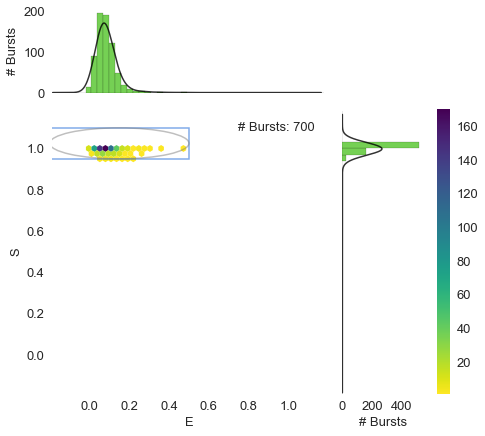

In [189]:
roi= dict(E1=-0.2, E2=0.5, S1=0.95, S2=1.1, rect=True)
ds3 = ds.select_bursts(select_bursts.ES, **roi)
g = alex_jointplot(ds3, cmap=colourscheme, marginal_color=20, vmax_fret=False)
bpl.plot_ES_selection(g.ax_joint, **roi);

This will fit a single gaussian to the filtered E, and convert the mean position to an alpha value, the leakage factor

alpha = 0.08096607511136686


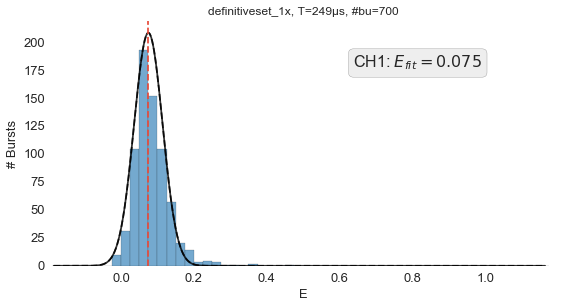

In [190]:
model = mfit.factory_gaussian()
ds3.E_fitter.fit_histogram(model=model, verbose=False, pdf=False)
dplot(ds3, hist_fret, binwidth=0.025, show_model=True, pdf=False, show_fit_value=True, fit_from="center");
params = ds3.E_fitter.params
Efit = params.to_dict()
Centre = Efit['center']
Edonly=Centre[0]
Edonly
alpha=Edonly/(1-Edonly)
print("alpha =", alpha)

# Selecting for AcceptorOnly

In [195]:
ds2 = d.select_bursts(select_bursts.size, add_naa=True, th1=50)
#ds2 = d.select_bursts(select_bursts.size, th1=-5, th2=5)
#ds2 = ds.select_bursts(select_bursts.naa, th1=50,)

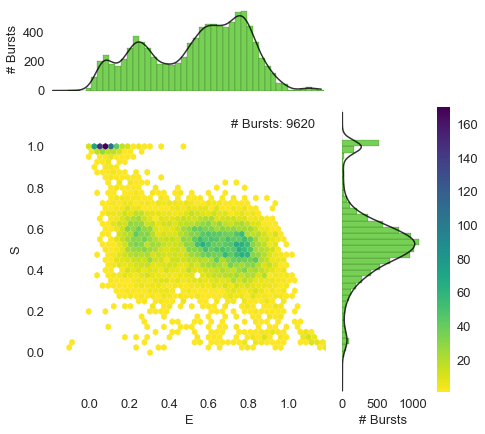

In [196]:
plt.rcParams['axes.facecolor'] = 'white'
grids = False
colourscheme = 'viridis_r'
g=alex_jointplot(ds2, cmap=colourscheme, marginal_color=20, vmax_fret=False) 

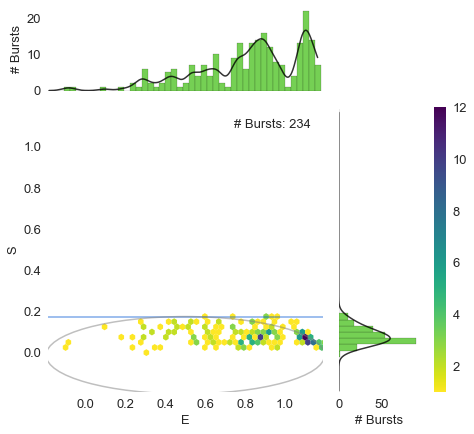

In [198]:
roi= dict(E1=-0.2, E2=1.2, S1=-0.2, S2=0.175, rect=True)
ds3 = ds2.select_bursts(select_bursts.ES, **roi)
g = alex_jointplot(ds3, cmap=colourscheme, marginal_color=20, vmax_fret=False)
bpl.plot_ES_selection(g.ax_joint, **roi);

This will extract delta, the direct excitation factor

delta = 0.07540089677411961


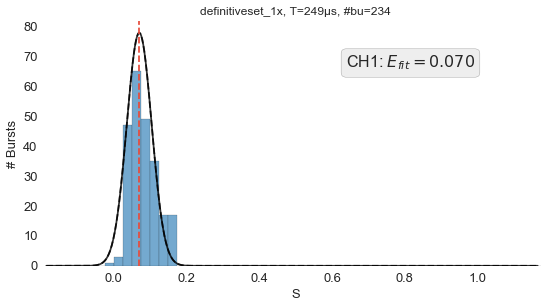

In [199]:
model = mfit.factory_gaussian()
ds3.S_fitter.fit_histogram(model=model, verbose=False, pdf=False)
dplot(ds3, hist_S, binwidth=0.025, show_model=True, pdf=False, show_fit_value=True, fit_from="center");
ds3.S_fitter.params
params = ds3.S_fitter.params
Sfit = params.to_dict()
Centre = Sfit['center']
Saonly=Centre[0]
delta=Saonly/(1-Saonly)
print("delta =", delta)

# Gamma and Beta Correction

In order for this to work well you will need a high and low FRET population in the same data set, you can do this by physically having the two populations present in the sample or by joining the two data sets in silico.

It works by fitting the equation

S = 1/(1+bg+(1-g)*b*E)

To do this we will need to apply the correction factors found so far, and to we'll also start by selecting just the part of the ES histogram with reasonable values to prevent erroneous points from throwing off the fit

   - Applying background correction.
   - Applying leakage correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


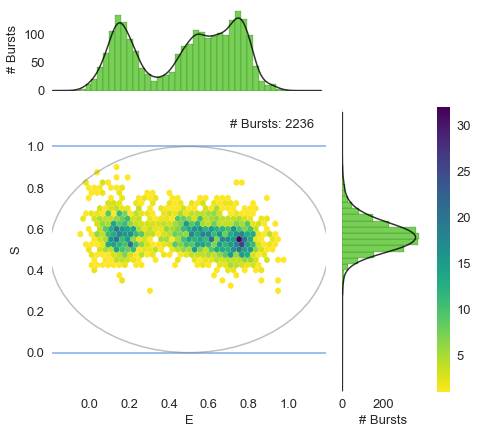

In [150]:
d.leakage = alpha
d.dir_ex = delta
ds2=burst_search_and_gate(d, F=(45, 45), m=10, mute=True)
ds2 = ds2.select_bursts(select_bursts.size, add_naa=True, th1=10)
ds2 = ds2.select_bursts(select_bursts.size, th1=50,)
ds2 = ds2.select_bursts(select_bursts.naa, th1=10,)
roi= dict(E1=-0.2, E2=1.2, S1=0.0, S2=1.0, rect=True)
ds3 = ds2.select_bursts(select_bursts.ES, **roi)
g = alex_jointplot(ds3, cmap=colourscheme, marginal_color=20, vmax_fret=False)
bpl.plot_ES_selection(g.ax_joint, **roi);

[[Model]]
    Model(_eval, nan_policy='omit')
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 2236
    # variables        = 2
    chi-square         = 11.376
    reduced chi-square = 0.005
    Akaike info crit   = -11804.217
    Bayesian info crit = -11792.793
[[Variables]]
    b:   0.86902610 +/- 0.011056 (1.27%) (init= 0.5)
    g:   0.76395682 +/- 0.018215 (2.38%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(b, g)                      = -0.875 



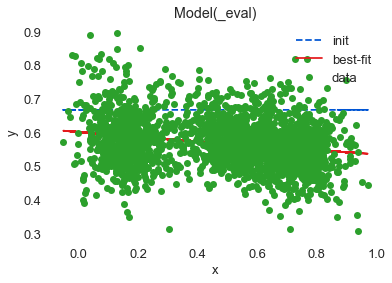

In [151]:
x = ds3.E[0]
y = ds3.S[0]
model = lmfit.models.ExpressionModel('1 / ( 1 + b * g + ( 1 - g ) * b * x )',
                             independent_vars=["x"], nan_policy = "omit")
params = model.make_params(b=0.5, g=1.0)
fit = model.fit(y, params, x=x)
fit.plot_fit(0)
print(fit.fit_report())

In [127]:
pars = fit.params
beta = pars['b']
beta=beta.value
gamma = pars['g']
gamma=gamma.value
print("gamma = ", gamma)

gamma =  1.0056444484802674


# Graphing with Correction Factors

In [128]:
d.leakage = alpha
d.dir_ex = delta
d.gamma = gamma
d.beta = beta

   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


In [120]:
d.burst_search(L=10, m=10, F=6)
ds = d.select_bursts(select_bursts.size, add_naa=True, th1=20)
ds2 = d.select_bursts(select_bursts.size, th1=50,)
ds2 = ds2.select_bursts(select_bursts.naa, th1=10, th2=100)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]


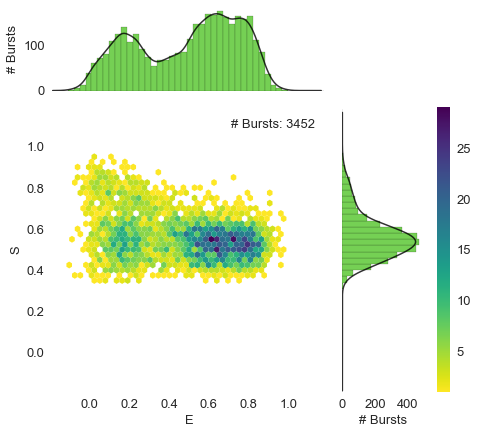

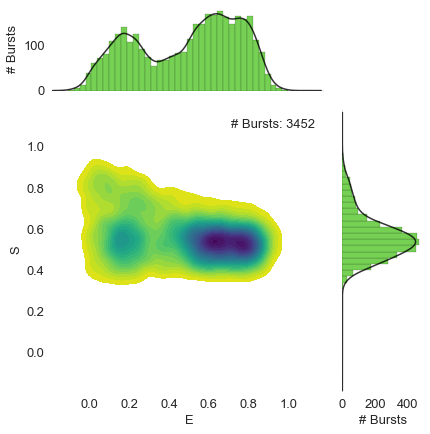

In [121]:
plt.rcParams['axes.facecolor'] = 'white'
grids = False
colourscheme = 'viridis_r'
g=alex_jointplot(ds2, cmap=colourscheme, marginal_color=20, vmax_fret=False) 
g=alex_jointplot(ds2, kind='kde', cmap=colourscheme, marginal_color=20, vmax_fret=False) 
if grids is False:
    g.ax_marg_x.grid(False)
    g.ax_marg_y.grid(False)
    g.ax_joint.grid(False)
if grids is True:
    g.ax_marg_x.grid(True)
    g.ax_marg_y.grid(True)
    g.ax_joint.grid(True)